In [65]:
from skimage import color, io
import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
from skimage.morphology import erosion, dilation, binary_erosion, binary_dilation
from skimage.morphology import disk
from skimage.morphology import square
from skimage.filters import prewitt
from skimage.filters import median
from skimage import segmentation
from skimage import measure
import math
from scipy.stats import norm
import pandas as pd
import seaborn as sns
from skimage.transform import rescale, resize
from skimage import color, data, io, morphology, measure, segmentation, img_as_ubyte
from skimage.filters import threshold_otsu
from skimage.filters import gaussian
from skimage.color import label2rgb
from scipy.spatial import distance
from skimage.transform import rotate
from skimage.transform import EuclideanTransform
from skimage.transform import SimilarityTransform
from skimage.transform import warp
from skimage.transform import swirl
from skimage.transform import matrix_transform
import glob
from sklearn.decomposition import PCA
import random
from skimage.util import compare_images

In [15]:
in_dir = "data/abdominal/"
im_name = "1-166.dcm"
ct = dicom.read_file(in_dir + im_name)
img = ct.pixel_array
kidney_l_roi = io.imread(in_dir + 'kidneyROI_l.png')
maskl = kidney_l_roi > 0
kidney_r_roi = io.imread(in_dir + 'kidneyROI_r.png')
maskr = kidney_r_roi > 0
kidneyl = img[maskl]
kidneyr = img[maskr]
mul, stl = norm.fit(kidneyl)
mur, stdr = norm.fit(kidneyr)
print(mul,mur)
liver_roi = io.imread(in_dir + 'LiverROI.png')
livmask = liver_roi > 0
liver = img[livmask]
muliver, stliver = norm.fit(liver)
t_1 = muliver - stliver
t_2 = muliver + stliver
binimg = (t_1 < img) & (img < t_2)

def spleen_finder(img, t_1, t_2):
    estimate = (img > t_1) & (img < t_2)
    footprint = disk(3)
    dilated = dilation(estimate, footprint)
    footprint = disk(10)
    eroded = erosion(dilated,footprint)
    footprint = disk(10)
    dilatedagain = dilation(eroded, footprint)
    label_img = measure.label(dilatedagain)
    region_props = measure.regionprops(label_img)
    min_area = 1500
    max_area = 7000
    min_perim = 300
    #max_perim = 350
    label_img_filter = label_img.copy()
    for region in region_props:
        crit1 = region.area > max_area or region.area < min_area
        crit2 = region.perimeter < min_perim
        if crit1 or crit2:
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0
    i_area = label_img_filter > 0
    return i_area
i_liver = spleen_finder(img,t_1,t_2)
gt_bin = liver_roi > 0
dice_score = 1 - distance.dice(i_liver.ravel(), gt_bin.ravel())
print(t_1,t_2)
print(dice_score)

107.45075421472937 107.56182572614108
51.7968823111612 100.87099317992372
0.782588123964987


In [27]:
glass_data = np.loadtxt('data/GlassPCA/glass_data.txt',skiprows=1)
glass_data = glass_data - np.mean(glass_data, axis = 0)
mins = np.min(glass_data, axis=0)
maxes = np.max(glass_data, axis=0)
difr = maxes-mins
glass_data = glass_data / difr

c_x = np.cov(glass_data.T)

values, vectors = np.linalg.eig(c_x)

v_norm = values / values.sum() * 100

print(c_x[0,0])
print(v_norm[:3].cumsum())
print(glass_data[0,1])

transformed = vectors.T.dot(glass_data.T)
absshit = np.abs(transformed)
print(np.max(absshit))

0.017772281053790966
[45.42956891 63.41966621 76.06912559]
0.034909704166959016
1.1211053359943872


In [40]:
def rotation_matrix(pitch, roll, yaw, deg = True):
    """
    Return the rotation matrix associated with the Euler angles roll, pitch, yaw.
    
    Parameters
    ----------
    pitch : float
        The rotation angle around the x-axis.
    roll : float
        The rotation angle around the y-axis.
    yaw : float
        The rotation angle around the z-axis.
    deg : bool, optional
        If True, the angles are given in degrees. If False, the angles are given
        in radians. Default: False.
    """
    if deg:
        roll = np.deg2rad(roll)
        pitch = np.deg2rad(pitch)
        yaw = np.deg2rad(yaw)

    R_x = np.array([[1, 0,             0,             0],
                    [0, np.cos(pitch),  -np.sin(pitch),  0],
                    [0, np.sin(pitch), np.cos(pitch),  0],
                    [0, 0,             0,             1]])

    R_y = np.array([[np.cos(roll), 0, np.sin(roll), 0],
                    [0, 1, 0, 0],
                    [-np.sin(roll), 0, np.cos(roll), 0],
                    [0, 0, 0, 1]])

    R_z = np.array([[np.cos(yaw),  -np.sin(yaw), 0, 0],
                    [np.sin(yaw), np.cos(yaw),  0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])

    R = np.dot(np.dot(R_x, R_y), R_z)

    return R
pitch_radians = 30 * math.pi / 180
rot_matrix = rotation_matrix(30, 0, 10)
print(rot_matrix)

[[ 0.98480775 -0.17364818  0.          0.        ]
 [ 0.15038373  0.85286853 -0.5         0.        ]
 [ 0.08682409  0.49240388  0.8660254   0.        ]
 [ 0.          0.          0.          1.        ]]


58979


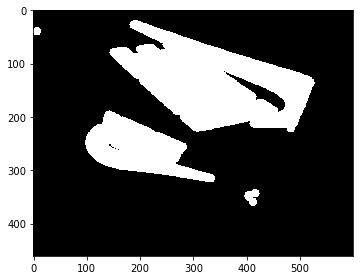

In [48]:
boxes = io.imread('data/nike.png')
hsvbox = color.rgb2hsv(boxes)
boxhue = hsvbox[:,:,0]
binhue = (boxhue > 0.3) & (boxhue < 0.7)
footprint = disk(8)
dilated = dilation(binhue,footprint)
print(dilated.sum())
io.imshow(dilated)
io.show()

In [64]:
shoe1 = io.imread('data/LMRegistration/shoe_1.png')
shoe2 = io.imread('data/LMRegistration/shoe_2.png')
src = np.array([[40,320],[425,120],[740,330]])
dst = np.array([[80,320],[380,155],[670,300]])
tform = SimilarityTransform()
tform.estimate(src,dst)
print(f'Scale {tform.scale}')

e_x = src[:, 0] - dst[:, 0]
error_x = np.dot(e_x, e_x)
e_y = src[:, 1] - dst[:, 1]
error_y = np.dot(e_y, e_y)
f = error_x + error_y
print(f"Landmark alignment error F: {f}")

src_transform = matrix_transform(src,tform.params)
e_x = src_transform[:, 0] - dst[:, 0]
error_x = np.dot(e_x, e_x)
e_y = src_transform[:, 1] - dst[:, 1]
error_y = np.dot(e_y, e_y)
f_after = error_x + error_y
print(f"Aligned landmark alignment error F: {f_after}")
print(f"Answer: alignment error change: {f - f_after:.0f}")

warped = warp(shoe1,tform.inverse)
val1 = img_as_ubyte(shoe2)
val2 = img_as_ubyte(warped)
print(val1[200,200,2] - val2[200,200,2])

Scale 0.8327055808649092
Landmark alignment error F: 10650
Aligned landmark alignment error F: 373.01770826994516
Answer: alignment error change: 10277
26


In [70]:
bg = io.imread('data/ChangeDetection/background.png')
nf = io.imread('data/ChangeDetection/new_frame.png')
graybg = color.rgb2gray(bg)
graynf = color.rgb2gray(nf)
newbg = 0.9 * graybg + (1 - 0.9) * graynf
difference = compare_images(newbg, graynf, method='diff')
dif_thres = 0.1
newbin = difference > 0.1
print(newbin.sum())
print(np.mean(newbg[150:200,150:200]))

25764
0.602417740972549


36073
0.44944431372549015


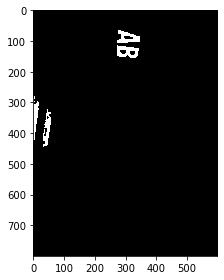

In [73]:
letters = io.imread('data/Letters/Letters.png')
r_comp = letters[:,:,0]
g_comp = letters[:,:,1]
b_comp = letters[:,:,2]
binletters = (r_comp > 100) & (g_comp < 100) & (b_comp <100)
footprint = disk(3)
eroded = erosion(binletters,footprint)
print(eroded.sum())
lettersg = color.rgb2gray(letters)
size = 8
footprint = np.ones([size, size])
med_img = median(lettersg, footprint)
print(med_img[100,100])
def letter_finder(img):
    label_img = measure.label(img)
    region_props = measure.regionprops(label_img)
    min_area = 1000
    max_area = 4000
    min_perim = 300
    #max_perim = 350
    label_img_filter = label_img.copy()
    for region in region_props:
        crit1 = region.area > max_area or region.area < min_area
        crit2 = region.perimeter < min_perim
        if crit1 or crit2:
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0
    i_area = label_img_filter > 0
    return i_area
i_letters = letter_finder(eroded)
io.imshow(i_letters)
io.show()

In [89]:
1000 / 230

4.3478260869565215

In [96]:
((1600 * 800 * 24) /  8000000) * 6.25

24.0

[0.23082787 0.13933354 0.12320351 0.11333118 0.10713935]
data/PizzaPCA/training\FindTheOlives.png data/PizzaPCA/training\BigSausage.png
data/PizzaPCA/training\GreenHam.png


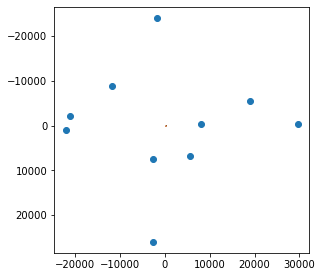

In [128]:
def create_u_byte_image_from_vector(im_vec, height, width, channels):
    min_val = im_vec.min()
    max_val = im_vec.max()

    # Transform to [0, 1]
    im_vec = np.subtract(im_vec, min_val)
    im_vec = np.divide(im_vec, max_val - min_val)
    im_vec = im_vec.reshape(height, width, channels)
    im_out = img_as_ubyte(im_vec)
    return im_out

files = glob.glob("data/PizzaPCA/training/*.png")
height, width, channels = io.imread(files[0]).shape
data_matrix = np.zeros((len(files), height * width * channels))
for i, f in enumerate(files):
    data_matrix[i, :] = io.imread(f).flatten()
meanza = np.mean(data_matrix, axis=0)
meanimg = create_u_byte_image_from_vector(meanza,height,width,channels)
io.imshow(meanimg)
cats_pca = PCA(n_components=5)
cats_pca.fit(data_matrix)

sub_data = data_matrix - meanimg.flatten()
sub_distances = np.linalg.norm(sub_data, axis=1)
funkyslice = np.argmax(sub_distances)
files[funkyslice]
print(cats_pca.explained_variance_ratio_)
components = cats_pca.transform(data_matrix)
#print(components[0])
plt.scatter(components[:,0],components[:,1])

p1 = np.argmin(components[:,0])
p2 = np.argmax(components[:,0])
print(files[p1],files[p2])
dtuslice = io.imread('data/PizzaPCA/super_pizza.png')
dtuslice = dtuslice.flatten()
dtuslice = dtuslice.reshape(1,-1)
dtuproj = cats_pca.transform(dtuslice)
comp_sub = components - dtuproj.flatten()
pca_distances = np.linalg.norm(comp_sub, axis=1)
whichpizze = np.argmin(pca_distances)
print(files[whichpizze])

In [139]:
img = io.imread('data/GeomTrans/lights.png')
rotation_angle = 11
rot_center = [40, 40]
rotated_img = rotate(img, rotation_angle, center=rot_center)
rotated_gray = color.rgb2gray(rotated_img)
thres = threshold_otsu(rotated_gray)
bin = rotated_gray > thres
print(bin.sum() / (bin.shape[0] * bin.shape[1]))
print(thres)

0.2579967948717949
0.419921875


In [137]:
bin.shape[1]

800